# **Introduction**

Kingdom classification by machine learning has immediate application in bioinformatics. Many metagenomic studies of the human gut microbiome utilize the whole genome shotgun sequencing (WGSS) paradigm that indiscriminantly sequences all DNA samples present in a culture without respect to organism of origin. This leads to human cellular DNA mixing with the DNA of over ten thousand unique bacterial species, and produces a significant challenge for traditional genome analytic methods to classify the DNA samples with speed and accuracy. A machine learning approach could increase the speed of sample classification and decrease the number of mis- or unclassified samples in a WGSS data set. This would reduce the cost, improve result quality, and reduce the waste in these studies. 

---

In this project, I used machine and deep learning algorithms to classify over 13,000 DNA samples into their correct kingdom of life. This task simulated the scale of metagenomic study sample classification. I used 4 models - logistic regression, decision tree, k-nearest neighbors, and a sequential neural network - and present the performance metrics of each on this problem. The k-nearest neighbors and sequential neural network models successfully classified 93% of validation set samples into the correct kingdom. Training the two models required less than 10 minutes each to achieve this level of accuracy. These results demonstrate the potential of machine learning models to rapidly understand hidden patterns present in genomic data and successfully classify organisms by DNA. 

In [ ]:
import pandas as pd 
import numpy as np

class PreProcessing: 
  def load_csv(filename): 
    ''' Load file from Drive as pandas dataframe '''
    df = pd.read_csv(filename, dtype='unicode')
    return df 


  def remove_extra_features(df):  
    ''' Remove unnecessary cols from dataframe '''
    df.drop('SpeciesName', axis=1, inplace=True)
    df.drop('SpeciesID', axis=1, inplace=True)
    df.drop('DNAtype', axis=1, inplace=True)
    df.drop('Ncodons', axis=1, inplace=True)
    return df


  def replace_non_floats(df): 
    ''' 3 locations with the dataframe that should contain floats 
        representing codon frequencies instead have erroneous strings.
        This method replaces said strings with empty spaces. '''
    df['UUU'] = df['UUU'].str.replace(r'non-B hepatitis virus', '')
    df['UUU'] = df['UUU'].str.replace(r'12;I', '')
    df['UUC'] = df['UUC'].str.replace(r'-', '')

    return df 


  def convert_df_to_numeric(df): 
    ''' After filtering out all non-float values from input dataframe, run this 
        method to convert the input data to float type. '''
    target = df['Kingdom']  # store only non-numeric col 

    temp = df.drop('Kingdom', axis=1)  # drop target col from temp df 
    temp = temp.apply(pd.to_numeric)  # convert non-target cols to numeric 
    temp = temp.fillna(-99)  # handle NaNs

    df = pd.concat([target, temp], axis=1)  # merge target, numeric cols
    return df 

# **Step 1: Data Preprocessing**

## **Background** 

The four bases of DNA, adenine, cytosine, guanine, and thiamine, store all the information necessary to create life. These bases group into functional triplets, *codons*, that translate into amino acids, the building blocks of proteins. The 4 unique DNA bases produce 64 unique codons. Each codon has a unique 3 base sequence not shared by any other codon. 

## **Preprocessing**

I accessed the dataset used in this project from the [UC Irvine machine learning repository](https://archive.ics.uci.edu/ml/datasets/Codon+usage). The author of a recent study currently in preprint provided this dataset for public use through UCI. 

To preprocess the raw dataset after importing it, I used the standard Python data science libraries, NumPy and Pandas. I imported the file as a Pandas data frame that contained 69 features and 13,028 instances. Columns 1 encoded the kingdom feature, which I used as the target for machine learning prediction. This feature contained 1 of 11 possible values for each instance. 


Columns 2-5 encoded DNA Type, Species ID, NCodons (total number of codons), and Species Name, which I filtered out because I did not need them for training. Columns 6-69 encoded Codon Frequencies for each of the 64 possible codons within an organism. I preserved these columns during preprocessing because Codon Frequencies formed the input features for each machine learning model.


In [ ]:
# load data and preprocess
codons = PreProcessing.load_csv('codon_usage.csv')
codons = PreProcessing.remove_extra_features(codons)
codons = PreProcessing.replace_non_floats(codons)
codons = PreProcessing.convert_df_to_numeric(codons)

# **Step 2: Data Visualization** 


There are 0 missing values in the dataset
There are  13028 samples in the dataset.
There are  65 features in the dataset.


,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,AUA,AUG,GUU,GUC,GUA,GUG,GCU,GCC,GCA,GCG,CCU,CCC,CCA,CCG,UGG,GGU,GGC,GGA,GGG,UCU,UCC,UCA,UCG,AGU,AGC,ACU,ACC,ACA,ACG,UAU,UAC,CAA,CAG,AAU,AAC,UGU,UGC,CAU,CAC,AAA,AAG,CGU,CGC,CGA,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
count,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.00000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000
mean,0.009616,0.015841,0.020637,0.014104,0.017820,0.018288,0.019044,0.018450,0.028352,0.025041,0.018294,0.021135,0.017647,0.015175,0.013621,0.016443,0.019935,0.023804,0.019062,0.011699,0.012944,0.01265,0.015694,0.008598,0.011611,0.017217,0.019063,0.018426,0.010530,0.014700,0.013245,0.015392,0.007161,0.009647,0.011086,0.015974,0.019374,0.019109,0.008226,0.018207,0.016175,0.019366,0.015487,0.022531,0.021981,0.007290,0.007595,0.011540,0.012172,0.028504,0.021530,0.008008,0.009659,0.006965,0.005454,0.009929,0.006422,0.024178,0.021164,0.028290,0.021683,0.001645,0.000592,0.006178
std,1.227011,0.867637,0.020709,0.009280,0.010586,0.014572,0.024250,0.016578,0.017507,0.014600,0.016044,0.008163,0.009953,0.010069,0.008315,0.011719,0.009890,0.017244,0.009112,0.013572,0.006765,0.00911,0.009606,0.008960,0.006569,0.010492,0.014768,0.009325,0.007139,0.008950,0.007594,0.009217,0.006120,0.006498,0.006571,0.008210,0.012453,0.013001,0.006774,0.011818,0.007353,0.011300,0.011284,0.015032,0.009510,0.006231,0.006440,0.006843,0.006604,0.017890,0.014577,0.006310,0.010680,0.004787,0.006605,0.008574,0.006387,0.013828,0.013041,0.014342,0.015018,0.001834,0.000907,0.010344
min,-99.000000,-99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.013910,0.015380,0.005610,0.007107,0.010890,0.007830,0.005307,0.007180,0.016360,0.015130,0.006320,0.015788,0.010520,0.008220,0.006940,0.006900,0.013300,0.010330,0.012990,0.002940,0.008430,0.00571,0.009250,0.002510,0.007107,0.009980,0.008977,0.011967,0.005577,0.008680,0.007820,0.008860,0.002577,0.004280,0.006707,0.010618,0.010050,0.010080,0.003180,0.009650,0.010960,0.012850,0.005848,0.011360,0.015560,0.002660,0.003600,0.007030,0.007187,0.017315,0.010245,0.003150,0.002880,0.003340,0.001220,0.001690,0.001170,0.012380,0.011860,0.017360,0.009710,0.000560,0.000000,0.000410
50%,0.021750,0.021905,0.015260,0.013360,0.016130,0.014560,0.009685,0.012800,0.025475,0.021540,0.014140,0.022000,0.017135,0.013160,0.012670,0.014520,0.018810,0.020245,0.018590,0.007080,0.012410,0.01099,0.014300,0.005670,0.012060,0.015545,0.015390,0.017520,0.009760,0.013730,0.012460,0.014600,0.005600,0.009450,0.010560,0.015680,0.017185,0.016660,0.006550,0.016080,0.015430,0.019040,0.014510,0.019800,0.021170,0.006160,0.006530,0.010620,0.011460,0.025315,0.021090,0.006875,0.005660,0.005990,0.003530,0.009270,0.004545,0.025420,0.019070,0.026085,0.020540,0.001380,0.000420,0.001130
75%,0.

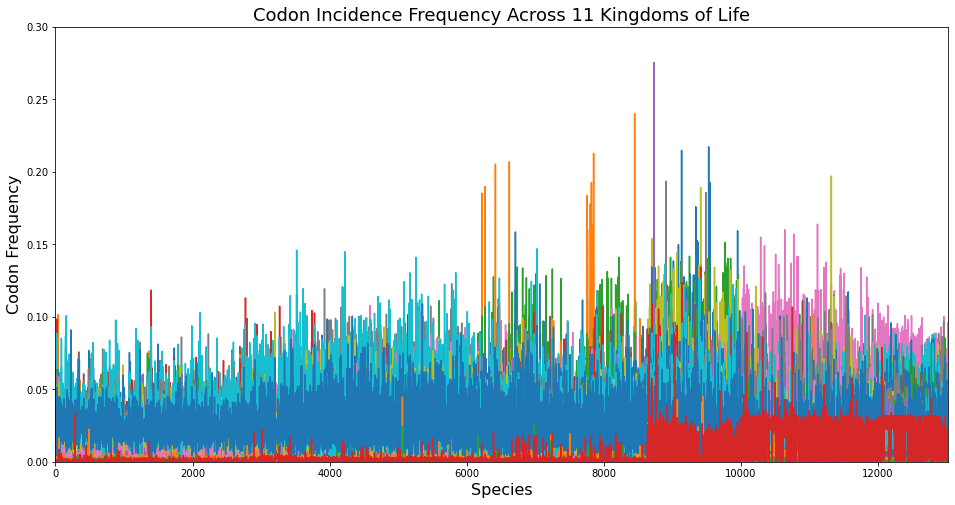

In [ ]:
import matplotlib.pyplot as plt

# check for NaNs in dataframe
nan_count = codons.isnull().sum().sum()
# store number of samples and features 
num_features = len(codons.columns)
num_samples = len(codons)
# print preprocessing statistics 
print('There are', nan_count, 'missing values in the dataset')
print('There are ',num_samples,'samples in the dataset.')
print('There are ', num_features, 'features in the dataset.')

# plot codon frequencies 
codons.plot(figsize=(16,8), legend=False, xlim=(0, len(codons)), ylim=(0,0.3))
plt.xlabel('Species',fontsize=16)
plt.ylabel('Codon Frequency', fontsize=16)
plt.title('Codon Incidence Frequency Across 11 Kingdoms of Life', fontsize=18)
# dataframe statistics
codons.describe()

## **Exploratory Data Analysis** 

I plotted the 64 codon frequency values for each organism across the full dataset. Each x axis point represented one unique species. The y axis plotted each of their 64 codon frequencies. Most of the codon frequencies in each organism occurred with less than 10% frequency. Only 3 codons presented greater than 20% frequency in at least one organism. On average, a given codon occurred with less than 10% frequency. 

If organisms had a random distribution of codons, then each codon should occur with ~1.56% frequency. This did not occur as frequencies varied from 0.00% to 27.5%. Therefore, there exists some pattern in codon frequency. This indicated that machine or deep learning algorithms could successfully predict an organism's kingdom of life if they could extract this pattern. 

---



# **Step 3: Data Processing**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

class DataTransformations: 
  def create_X_y_sets(df): 
    ''' This method accepts the preprocessed dataframe from the PreProcessing
        class and splits it into X (features) and y (labels) subframes. 
        Input: preprocessed dataframe
        Output: feature, labels dataframes '''
    features = df.drop('Kingdom', axis=1)
    labels = df['Kingdom']
    return features, labels


  def encode_categories(labels_train, labels_val, labels_test): 
    ''' This method maps any non-int values from the labels subframes and maps 
        each value to the integers using SKL's label encoder function. Must 
        pass train, validation, and test subframes together because the label 
        encoder learns the mapping from the train set first and then applies it
        to the validation and test sets. 
        Inputs: train, validation, test label sets 
        Outputs: integer-mapped train, validation, test label sets '''
    le = LabelEncoder()  # instantiate encoder 
    enc_label_train = le.fit_transform(labels_train)  # fit and xform train set 
    enc_label_val = le.transform(labels_val)  # xform validation set 
    enc_label_test = le.transform(labels_val)  # xform test set 

    return enc_label_train, enc_label_val, enc_label_test


  def split_datasets(X, y, split_fraction): 
    ''' This method accepts the X and y subframes from create_X_y_sets and 
        splits them into train and teset sets. 'Split_fraction' controls the 
        amount of data placed into the test set. 
        Inputs: X, y subframes and decimal value to split data 
        Outputs: 2 X, 2 y subframes containing x% and (1-x)% of data'''
    X_big, X_small, y_big, y_small = train_test_split(X, y, 
                                                      test_size=split_fraction, 
                                                      random_state=42)
    return X_big, X_small, y_big, y_small

  
  def scale_data(df_train, df_val, df_test): 
    ''' This method normalizes the input datasets onto [0,1] using SKL's 
        Min-Max Scaler. Must pass train, validation, and test sets together 
        because the scaler fits the train set [0,1] then applies this mapping
        onto the validation and test sets. Smallest value in train set -> 0, 
        largest value in train set -> 1. 
        Inputs: train, validation, test sets
        Outputs: normalized train, validation, test sets '''
    min_max_scaler = MinMaxScaler()  # instantiate scaler from SKL
    min_max_scaler.fit(df_train)  # call scaler on input dataframe to train
    df_train = min_max_scaler.transform(df_train)  # transform train set
    df_val = min_max_scaler.transform(df_val)  # transform validation set
    df_test = min_max_scaler.transform(df_test)  # transform test set 

    return df_train, df_val, df_test

In [ ]:
# create X, y sets 
X, y = DataTransformations.create_X_y_sets(codons)
# create train, and temp set (will split temp into validation and test sets)
X_train, X_temp, y_train, y_temp = DataTransformations.split_datasets(X, y, 0.2)
# create validation and test set
X_val, X_test, y_val, y_test = DataTransformations.split_datasets(X_temp, 
                                                                  y_temp, 0.5)
# normalize input data sets (train/validation/test)
X_train, X_val, X_test = DataTransformations.scale_data(X_train, X_val, X_test)

The preprocessed data frame I used for EDA contained 64 columns of features, Codon Frequencies, and one column of labels, Kingdom. I split this data frame into X and y subframes by the features and label columns respectively. Then I split these 2 subframes further into train, validation, and test subsets in an 80:10:10 ratio using Sci-Kit Learn's (SKL) train_test_split method. 

The train subset fed into each machine learning model for parameter fitting and hyperparameter tuning. I used the validation set to check the prediction metrics of each model after training concluded, and I felt satisfied with the training performance. No model had exposure to the test subset until I finalized training and validation on all models. 

After creating the train, validation, and test subsets, I normalized the input features for each subset using MinMaxScaler from SKL. This method rescaled the train, validation, and test feature subsets from 0 to 1, where 0 denoted the smallest value in the train set and 1 denoted the largest value in the train set. 

Note: The DataTransformation class contains an encoding method that uses SKL's LabelEncoder to the inputs to the integers. I needed this method to map the kingdom labels to the integers for the sequential neural network used downstream. The traditional machine learning models did not require integer labels so I did not call this method at this moment.

---



# **Step 4: Baseline ML Model**

I instantiated an SKL logistic regression model with the default parameters as a baseline model to compare against other algorithms. However, I had to specify ‘multinomial’ as the value for the multi_class parameter because my data had more than 2 classes. Additionally, the default value for max_iter did not allow for the optimization solver, LBFGS, to converge during training. Therefore, I passed ‘1,000’ as the value which would manually cut training at said iteration if convergence had not yet occurred. No further errors occurred with this value. 

I used the logistic regressor as the baseline model to compare others because it had no hyperparameters to tune and no parameters to vary other than that to set the classification problem to non-binary. It also has a fast training time so it could return results quickly. 

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

class ModelMetrics: 
  def print_model_accuracy(model, X, y_actual, network):  
    if network == 0: 
      accuracy = model.score(X, y_actual)  # pass input data 
    elif network != 0: 
      accuracy = model.evaluate(X, y_actual)[1]
    print('Model accuracy:', accuracy*100, '%')  # print model accuracy 
    return accuracy 


  def print_classification_report(y_actual, y_pred, network): 
    if network == 0: 
      report = classification_report(y_actual, y_pred, zero_division=0)
    elif network != 0:  
      y_pred = np.argmax(y_pred, axis=1)
      report = classification_report(y_actual, y_pred, zero_division=0)
    print('Classification Report:\n', report)  # print classification report 
    return report 


  def plot_confusion_matrix(y_actual, y_pred, labels, network): 
    # instantiate figure, axes objects for plotting and set dimensions
    fig, axes = plt.subplots()  
    fig.set_figheight(8)  
    fig.set_figwidth(16)  
    # plot confusion matrix 
    if network == 0: 
      ConfusionMatrixDisplay.from_predictions(y_actual, y_pred, cmap='cividis', 
                                              ax=axes, colorbar=False)
    elif network != 0: 
      y_pred = np.argmax(y_pred, axis=1)
      ConfusionMatrixDisplay.from_predictions(y_actual, y_pred, cmap='cividis', 
                                              ax=axes, colorbar=False)
      axes.xaxis.set_ticklabels(labels.values.astype(str));
      axes.yaxis.set_ticklabels(labels.values.astype(str));
      
    # set axes titles and labels 
    #axes.set_title('Confusion Matrix', fontsize=18)  
    axes.set_xlabel('Model Predicted Label', fontsize = 14)
    axes.set_ylabel('True Label', fontsize = 14)
    return 


  def plot_kNN_accuracies(kNN_obj, metric, nhbd): 
    # store kNN scores in dataframe, remove extraneous cols, and sort by metrics 
    df = pd.DataFrame(kNN_obj.cv_results_)  
    df = df[['param_n_neighbors', 'param_metric', 'param_algorithm', 
             'mean_test_score', 'rank_test_score']]  
    df = df.sort_values(by='param_n_neighbors')
    # break object-wide dataframe into metric-based subframes
    chebys = df[df['param_metric'].astype(str).str.contains('chebys')].reset_index(drop=True)
    euclid = df[df['param_metric'].astype(str).str.contains('euclid')].reset_index(drop=True)
    manhat = df[df['param_metric'].astype(str).str.contains('manhat')].reset_index(drop=True)
    # instantiate figure, axes objects for plotting and set dimensions
    fig, axes = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(12)
    # plot (# neighbors) x (accuracies) for each metric 
    axes.plot(chebys['param_n_neighbors'], chebys['mean_test_score'], 
              label='Chebyshev', color='k', linestyle='--')
    axes.plot(euclid['param_n_neighbors'], euclid['mean_test_score'], 
              label='Euclidean', color='k', linestyle='-')
    axes.plot(manhat['param_n_neighbors'], manhat['mean_test_score'], 
              label='Manhattan', color='k', linestyle=':')
    # set axis titles and labels 
    #axes.set_title('kNN Classification Accuracies', fontsize=18)
    axes.set_xlabel('K values (Number of Neighbors', fontsize=14)
    axes.set_ylabel('Model Accuracy', fontsize=14)
    axes.set_xticks(nhbd)
    axes.legend()
    return df


  def plot_network_accuracies(network_history): 
    fig, axes = plt.subplots(2)
    fig.set_figheight(8)
    fig.set_figwidth(12)
    # plot train and validation losses 
    axes[0].plot(network_history.history['loss'], linestyle='-', color='k', 
                label='Training')
    axes[0].plot(network_history.history['val_loss'], linestyle='--', color='k',
                label='Validation')
    #axes[0].set_title('Train and Validation Loss', fontsize=18)
    axes[0].set_xlabel('Epoch', fontsize=14)
    axes[0].set_ylabel('Loss', fontsize=14)
    axes[0].legend()
    # plot train and validation accuracies 
    axes[1].plot(network_history.history['sparse_categorical_accuracy'], 
                linestyle='-', color='k', label='Training')
    axes[1].plot(network_history.history['val_sparse_categorical_accuracy'], 
                linestyle='--', color='k',label='Validation')
    #axes[1].set_title('Train and Validation Accuracy', fontsize=18)
    axes[1].set_xlabel('Epoch', fontsize=14)
    axes[1].set_ylabel('Accuracy', fontsize=14)
    axes[1].legend(loc='lower right')
    fig.tight_layout()
    return 

Model accuracy: 81.04374520337683 %
Classification Report:
               precision    recall  f1-score   support

         arc       0.71      0.36      0.48        14
         bct       0.85      0.93      0.89       299
         inv       0.81      0.46      0.59       150
         mam       0.72      0.65      0.68        43
         phg       0.80      0.21      0.33        19
         pln       0.74      0.84      0.78       245
         pri       0.67      0.15      0.25        13
         rod       0.83      0.20      0.32        25
         vrl       0.83      0.91      0.87       289
         vrt       0.83      0.94      0.88       206

    accuracy                           0.81      1303
   macro avg       0.78      0.57      0.61      1303
weighted avg       0.81      0.81      0.79      1303



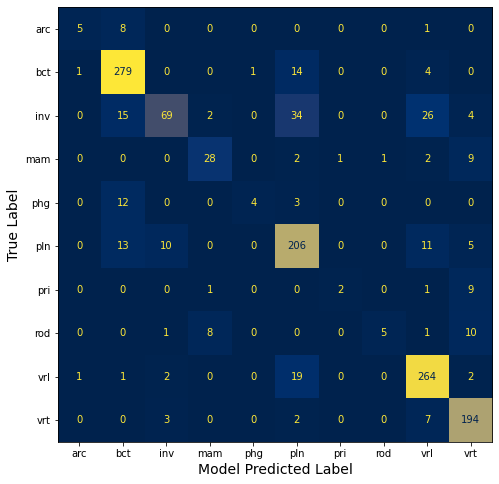

In [ ]:
from sklearn.linear_model import LogisticRegression

# instantiate multinomial log reg model w 1,000 iteration cut-off to converge
log_reg = LogisticRegression(multi_class='multinomial', max_iter=1000,
                             random_state=42)  
# fit model on train data
log_reg.fit(X_train, y_train)
# create predictions on val data
predictions_val_log = log_reg.predict(X_val)
# call metrics functions to review model performance
accuracy_log = ModelMetrics.print_model_accuracy(log_reg, X_val, y_val, 
                                                 network=0)
report_log = ModelMetrics.print_classification_report(y_val, 
                                                      predictions_val_log, 
                                                      network=0)
ModelMetrics.plot_confusion_matrix(y_val, predictions_val_log, labels=0, 
                                   network=0)

## **Logistic Regression Performance** 

If the logistic regressor randomly guessed the kingdom of each organism, then I expected ~10% accuracy from the model. However, this model returned 81.4% classification accuracy for kingdom given an organism’s codon frequencies in the validation set. This indicated that machine learning models could successfully classify kingdom given codon frequencies and warranted further investigation into more complex parameters. 


The classification report for this model indicates that no class had greater than 90% precision. The ‘bacteria’ class had the highest precision at 85% while the ‘primate’ class had the lowest precision at 67%. This model had greater than 90% recall for the ‘vertebrate’, ‘bacteria’, and ‘virus’ classes with 94%, 93%, and 91% respectively. ‘Phage’, ‘rodent’, and ‘primate’ had the lowest recall scores at 21%, 20%, and 15% respectively. Since I did not tune any parameters of this model after instantiation, I considered this a strong result and positive indicator for the potential of machine learning classifiers for accurate predictions. 

---



# **Step 5: Comparing Classification Metrics from Multiple Model**


## **Cross Validation with Randomized Parameter-Space Search for the Optimal Decision Tree**

SKL provided 12 parameters for tuning in its decision tree object. I chose to test the effect of 5 parameters on model performance: criterion, max_features, max_depth, min_samples_split, and min_samples_leaf. The values I passed for each parameter led to 1,900 possible ways to instantiate a decision tree. Therefore, I applied a randomized search through the parameter space to find the optimal decision tree using SKL’s RandomizedSearchCV method. I screened 100 candidate trees through a 25-fold cross validation scheme that split the train set into 5 folds and passed each fold 5 times into each candidate tree for training and validation. The random search and 25-fold cross validation generally required 15 minutes on a standard Google Collaboratory instance. 

In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import GridSearchCV

class CVModelTest: 
  def cross_validation(cv_splits, repetitions): 
    # instantiate m CV splits with n repetitions
    cv_folds = RepeatedKFold(n_splits=cv_splits, n_repeats=repetitions, 
                            random_state=1)  
    return cv_folds


  def random_CV_search(model, param_distrib, cv_splits, cv_repeats, candidates, parallel, X_train, y_train): 
    # call internal method to instantiate cross validation object w given params
    cv_folds = CVModelTest.cross_validation(cv_splits,cv_repeats)
    # randomly search param space for optimal model parameters
    random_search = RandomizedSearchCV(model, param_distrib, n_iter=candidates,
                                       n_jobs=parallel, cv=cv_folds, verbose=10, 
                                       random_state=1)
    # fit each random model iteration to train data
    random_search.fit(X_train, y_train)
    
    return random_search 


  def grid_CV_search(model, param_distrib, cv_splits, cv_repeats, parallel, X_train, y_train): 
    # call internal method to instantiate cross validation object w given params
    cv_folds = CVModelTest.cross_validation(cv_splits,cv_repeats)
    # randomly search param space for optimal model parameters
    grid_search = GridSearchCV(model, param_distrib, n_jobs=parallel, 
                               verbose=10, cv=cv_folds)
    # fit each grid iteration to train data 
    grid_search.fit(X_train, y_train)
    
    return grid_search


  def pull_best_model(search_obj, X_train, y_train, X_val): 
    opt_model = search_obj.best_estimator_  # pull best estimator from search obj
    opt_model.fit(X_train, y_train)  # re-fit best estimator to train data 
    predictions = opt_model.predict(X_val)  # store estimor predictions on valid set

    return opt_model, predictions 

Fitting 25 folds for each of 100 candidates, totalling 2500 fits
Model accuracy: 75.36454336147352 %
Classification Report:
               precision    recall  f1-score   support

         arc       0.50      0.21      0.30        14
         bct       0.81      0.87      0.84       299
         inv       0.59      0.61      0.60       150
         mam       0.73      0.77      0.75        43
         phg       0.27      0.16      0.20        19
         plm       0.00      0.00      0.00         0
         pln       0.72      0.69      0.71       245
         pri       0.38      0.46      0.41        13
         rod       0.72      0.52      0.60        25
         vrl       0.78      0.79      0.79       289
         vrt       0.86      0.85      0.86       206

    accuracy                           0.75      1303
   macro avg       0.58      0.54      0.55      1303
weighted avg       0.75      0.75      0.75      1303



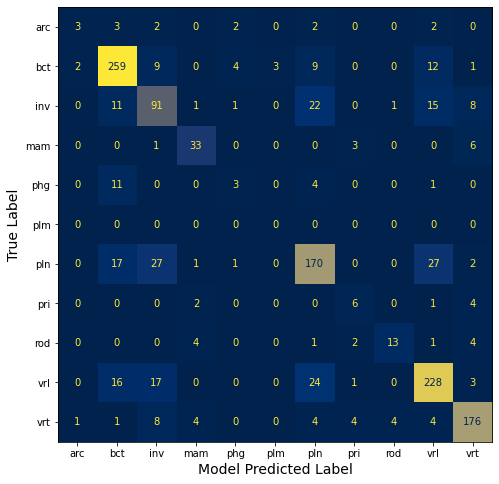

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# set values for decision tree params 
criterion = ['entropy', 'gini']
max_features = ['auto', None]
splitter = ['best']
max_depth = np.arange(1,20)
min_samples_split = [2,3,4,5,6]
min_samples_leaf = [1,2,3,4,5,6]
# initialize dictionary of params : values for decision tree
param_space = {'criterion':criterion, 'max_features': max_features, 
                  'max_depth': max_depth, 'splitter': splitter, 
                  'min_samples_split': min_samples_split, 
                  'min_samples_leaf': min_samples_leaf}
# instantiate decision tree
tree = DecisionTreeClassifier()
# set 5-fold CV, repeated 5x, for 25 candidate models
rand_tree = CVModelTest.random_CV_search(tree,param_space, 5, 5, 100, -1, 
                                         X_train, y_train)
# store best model from search space 
best_tree, predictions_val_tree = CVModelTest.pull_best_model(rand_tree, 
                                                              X_train, y_train, 
                                                              X_val)
# call metrics functions to review model performance
accuracy_tree = ModelMetrics.print_model_accuracy(best_tree, X_val, y_val, 
                                                  network=0)
report_tree = ModelMetrics.print_classification_report(y_val, 
                                                       predictions_val_tree, 
                                                       network=0)
ModelMetrics.plot_confusion_matrix(y_val, predictions_val_tree, labels=0,
                                   network=0)



## **Optimal Decision Tree Performance**

The best performing model from the search had 75.2% accuracy on the validation set, and used ‘entropy’ as its criterion, depth of 12, and required 4 min_samples_split.  

The optimal tree also lacked greater than 90% precision for any classes within kingdom like the logistic regressor. ‘Bacteria’ had the highest precision at 81% while ‘bacteriophage’ and ‘plasmid’ had the lowest at 23% and 0.00% respectively. However, only 1 instance of ‘plasmid’ passed to the model during validation. The ‘bacteria’ and ‘vertebrate’ classes had the highest recall at 87% and 84% respectively. No other classes had greater than 80% recall.  

Despite searching 100 candidate trees, the confusion matrix indicates that the optimal candidate still returned more misclassifications than the logistic regression model I used as a baseline. Because of this I chose to try a different classification paradigm rather than search more candidate trees or modify the parameter space.

---



## **Cross Validation with Grid Search for the Optimal k-Nearest Neighbors Model**

k-Nearest Neighbors (kNN) only had 1 hyperparameter, the number of neighbors (k). I searched for the best kNN model by varying k from 2 to 20. SKL also allowed modification of the distance metric used to find the k nearest neighbors. I performed a grid search of every possible candidate with 25-fold cross validation because I had fewer (hyper)parameters to search than with the decision tree. The grid search fit 114 candidates to each possible combination of parameter and hyperparameter. 


Fitting 5 folds for each of 114 candidates, totalling 570 fits
Model accuracy: 92.24865694551036 %
Classification Report:
               precision    recall  f1-score   support

         arc       0.81      0.93      0.87        14
         bct       0.94      0.96      0.95       299
         inv       0.91      0.83      0.87       150
         mam       0.75      0.91      0.82        43
         phg       0.75      0.79      0.77        19
         plm       0.00      0.00      0.00         0
         pln       0.89      0.96      0.92       245
         pri       0.60      0.69      0.64        13
         rod       0.95      0.72      0.82        25
         vrl       0.97      0.93      0.95       289
         vrt       0.97      0.95      0.96       206

    accuracy                           0.92      1303
   macro avg       0.78      0.79      0.78      1303
weighted avg       0.93      0.92      0.92      1303



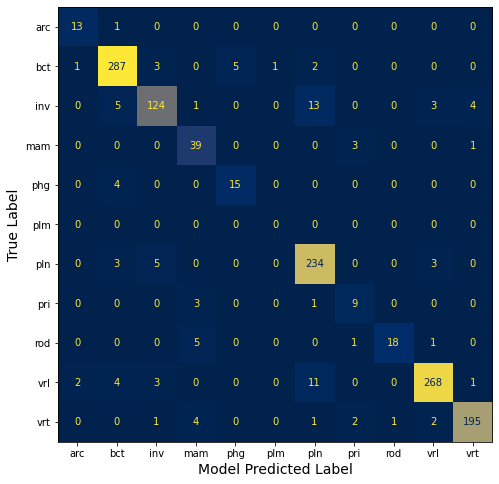

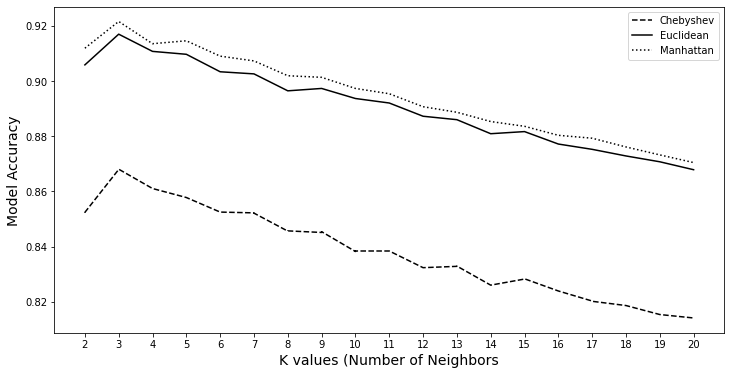

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import DistanceMetric

# initialize parameter space for kNN classifier and store in dictionary 
nbhd = np.arange(2,21)
distances = ['euclidean', 'chebyshev', 'manhattan']
algorithms = ['ball_tree', 'kd_tree']
param_space = {'n_neighbors': nbhd, 'metric': distances, 
               'algorithm': algorithms}
# instantiate kNN classifier, perform n-fold CV within parameter space search 
kNN = KNeighborsClassifier()
grid_search_kNN = CVModelTest.grid_CV_search(kNN, param_space, 5, 1, -1, 
                                             X_train, y_train)
# store best model and its predictions on validation set 
best_kNN, predictions_val_knn = CVModelTest.pull_best_model(grid_search_kNN, 
                                                            X_train, y_train, 
                                                            X_val)
# call metrics functions to review model performance
accuracy_knn = ModelMetrics.print_model_accuracy(best_kNN, X_val, y_val, 
                                                 network=0)
report_knn = ModelMetrics.print_classification_report(y_val, 
                                                      predictions_val_knn, 
                                                      network=0)
ModelMetrics.plot_confusion_matrix(y_val, predictions_val_knn, labels=0, 
                                   network=0)
df = ModelMetrics.plot_kNN_accuracies(grid_search_kNN, distances, nbhd)

## **Best kNN Classification Performance**

The best k-Nearest Neighbors model returned 92.2% accuracy on the validation set, higher than the logistic regression baseline and the optimal decision tree models. This model utilized the Manhattan distance with k = 3. In comparison the optimal decision tree and logistic regression models had 75.2% and 81.0% accuracy on the validation data respectively. Classifiers that used the Euclidean distance returned similar accuracy as those that used the Manhattan distance. Chebyshev distance metric returned similar accuracy trends for each k as Euclidean and Manhattan but had approximately 6% lower accuracy for each model. 

‘Virus’, ‘vertebrate’, and ‘bacteria’ had the highest precision scores at 0.97, 0.97, and 0.94 respectively. These same 3 classes also had the highest recall scores at 0.93, 0.95, and 0.96 respectively. The validation set used to check these metrics did not contain any instances of the class ‘plasmid’. The confusion matrix indicated that all classes had more correct classifications and fewer misclassifications with the best kNN model compared to the logistic regression and optimal decision tree models. 

I would investigate clustering algorithms further due to the kNN model outperforming the baseline model in terms of accuracy and metrics. Performance could likely improve with the implementation of dimensionality reduction to decrease the number of redundant codons. More sophisticated algorithms like k-means clustering may also improve performance. 

---



## **Deep learning with a sequential neural network**

I used the Keras API to construct a neural network to test how deep learning performed compared to the traditional machine learning paradigms above. My model had a sequential architecture with exactly one input and output tensor per layer. This network had 2 hidden layers, both using the ReLU activation function, and both hosting 64 neurons each. The total number of parameters in each hidden layer equaled 4,160. Including the activation layer, the total model parameters reached 9,035. I compiled the model using the root mean square propagation optimizer, the cross-entropy loss function, and measured the performance using accuracy. 

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 codons (InputLayer)         [(None, 64)]              0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 predictions (Dense)         (None, 11)                715       
                                                                 
Total params: 9,035
Trainable params: 9,035
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
163/163 [==============================] - 2s 9ms/step - loss: 1.4458 - sparse_categorical_accuracy: 0.5470 - val_loss: 1.0991 - val_sparse_categorical_accuracy: 0.6285
Epoch 2/

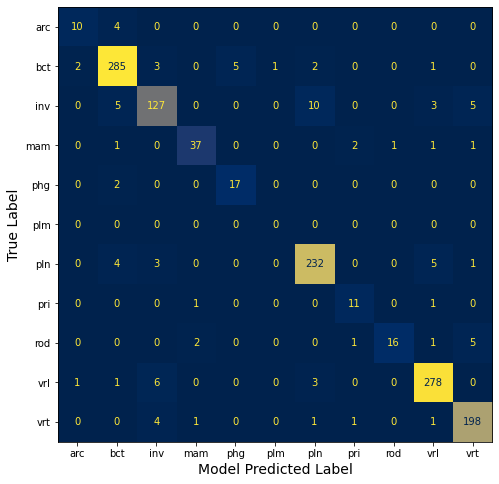

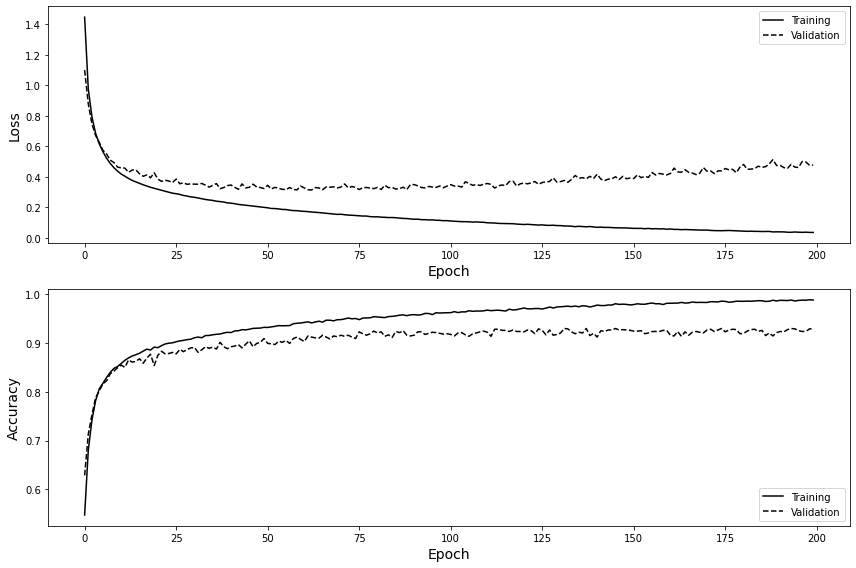

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers

# map categorical labels to integers for deep learning
labels = pd.Series(['arc', 'bct', 'inv', 'mam', 'phg', 'plm', 'pln', 'pri', 
                    'rod', 'vrl', 'vrt'])
y_train2, y_val2, y_test2 = DataTransformations.encode_categories(y_train, 
                                                                  y_val, y_test)
# initialize neural network and parameters
inputs = keras.Input(shape=(X_train.shape[1],), name="Input Layer")
x = layers.Dense(64, activation="relu", name="Hidden Layer 1")(inputs)
x = layers.Dense(64, activation="relu", name="Hidden Layer 2")(x)
outputs = layers.Dense(len(np.unique(y_train)), activation="softmax", 
                       name="Output layer")(x)
# instantiate and compile model 
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.RMSprop(), 
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
# print model summary
model.summary()
# train and validate model 
history = model.fit(X_train, y_train2, batch_size=64, epochs=200, 
                    validation_data=(X_val, y_val2))
# create predictions on val data
predictions_nn = model.predict(X_val)
# call metrics functions to review model performance
ModelMetrics.print_model_accuracy(model, X_val, y_val2, network=1)
ModelMetrics.print_classification_report(y_val2, predictions_nn, network=1)
ModelMetrics.plot_confusion_matrix(y_val2, predictions_nn, labels, network = 1)
ModelMetrics.plot_network_accuracies(history)


## **Sequential Neural Network Performance**

The neural network model returned 93.0% accuracy on the validation set after training. On a standard Google Collab GPU instance this required 90s for 200 epochs with a batch size of 64. This trained model performed equal to the best kNN model on the validation set in terms of accuracy. ‘Plasmid’, bacteria’, and ‘vertebrate’ classes had the highest precision scores at 0.96, 0.95, and 0.92 respectively. ‘Virus’, ‘vertebrate’, and ‘bacteria’ classes had the highest recall scores of 0.97, 0.96, and 0.93 respectively. Only kNN model had similar precision and recall metrics for the classes.

The most frequent misclassification occurred when the neural network mislabeled ‘primates’ as ‘invertebrates’. It made this error less frequently than the best kNN model and one-third as frequently compared to the logistic regression baseline. Overall, the classification report indicated similar performance to the best kNN classifier; however, the neural network required only 1.5 minutes to train rather than 15 minutes to return the best model.

Note: Loss did not converge for training or validation data sets after 200 epochs. Accuracy on validation set converged around 90% after 100 epochs of training. Training accuracy continued to improve and did not converge by the end of training. This could indicate overtraining. 


# **Step 6: Final Performance Evaluationt**

I passed the test sets to each finalized and trained model simultaneously in order to prevent human biases from influencing this project. No model had previous exposure to the test data set until this stage. 

In [ ]:
test_logreg = log_reg.score(X_test, y_test)
test_tree = best_tree.score(X_test, y_test)
test_knn = best_kNN.score(X_test, y_test)
test_nn = model.evaluate(X_test, y_test2, batch_size=64, verbose=0)[1]

print('Logistic Regression Test Accuracy:', test_logreg)
print('Optimal Decision Tree Test Accuracy:', test_tree)
print('Best kNN Classification Accuracy:', test_knn)
print('Sequential Neural Network Test Accuracy:', test_nn)

Logistic Regression Test Accuracy: 0.8158096699923254
Optimal Decision Tree Test Accuracy: 0.7398311588641596
Best kNN Classification Accuracy: 0.9255564082885649
Sequential Neural Network Test Accuracy: 0.18572525680065155


## **Test set performance for each model**

Test accuracies reflected the validation set accuracies for each model except the sequential neural network. Only the neural network performed significantly worse on the test set compared to the training and validation accuracies. The sequential neural network consistently returned greater than 90% validation accuracy after 75-100 epochs of training, which matched the kNN classifiers for k < 8. However, the neural network performed the worst out of all the models on the test data set with only 18.5% accuracy, compared to the best kNN classifier that had 92.6% accuracy. 



# **Step 7: Conclusions and Future Work**

The performance of the best kNN model on the test set demonstrates that machine learning algorithms can successfully classify the kingdom of life a DNA sample originates from accurately and quickly. Finding the best kNN model required 15 minutes on average and evaluating it on the validation and test sets took seconds. Traditional bioinformatic search and matching algorithms cannot return results for over 10,000 DNA samples in this short of time with this level of accuracy. Finer tuning of the data by reducing its dimensionality with PCA or tSNE and using more advanced clustering algorithms could further improve classification performance as well. 

---

Recommendations for future studies to improve neural network performance: 
 
1.   The next time I conduct this study, I would recommend decreasing the number of training epochs to 100 because the validation accuracy converges at that point while training accuracy continues to increase – a common sign of overfit models.
2.   Additionally, the validation loss converges while the training loss continues to decrease. After approximately 125 epochs the validation loss begins to increase so I would recommend not training beyond 125 epochs in a future update to this study. 
3.   Test a convolutional or recurrent neural network architecture. I used the sequential model because it provided fast training times since not all neurons synapsed onto the following layer.

Recommendations for future studies to improve overall model performance:
1.   Use stratified sampling to create the train, validation, and test data sets to ensure the same proportion of classes occur in each set to avoid a situation where the validation or test set contains 0 instances of a class. 